Dimensiones de la imagen: (335, 612, 3)
Umbral Otsu calculado: 170.00
Número de contornos encontrados: 12
Contornos después de filtrar (área > 500): 10


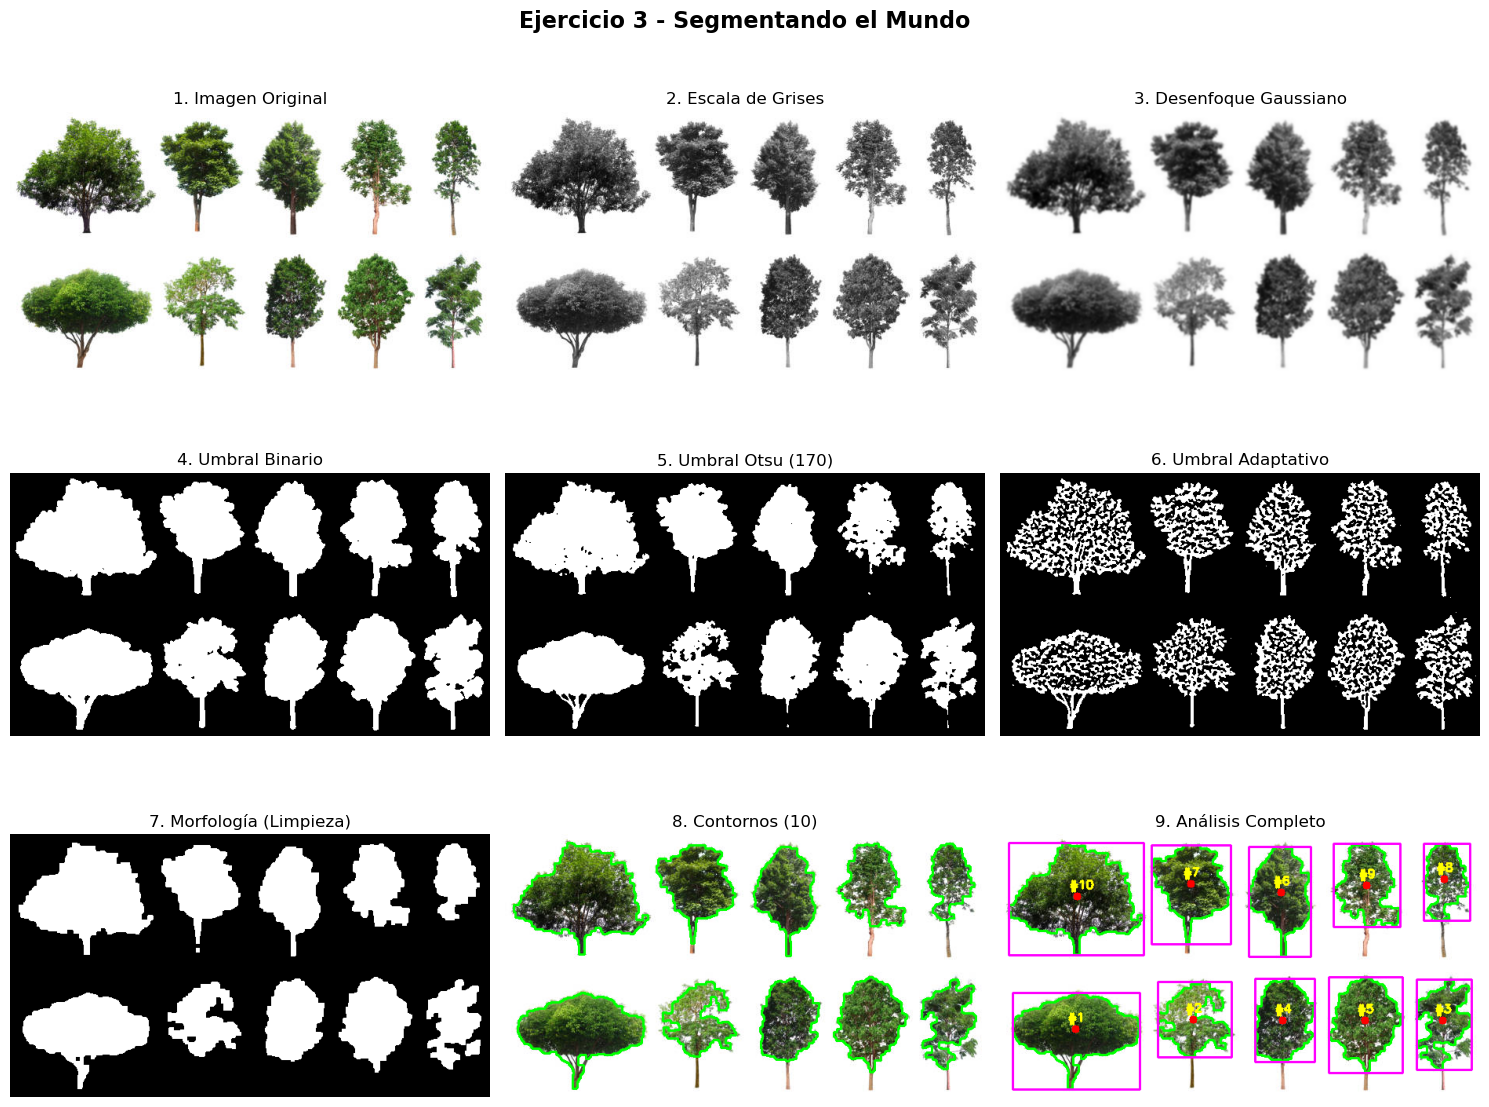


ANÁLISIS DE CONTORNOS DETECTADOS

Árbol #1:
  • Centroide: (96, 248)
  • Área: 9994.50 píxeles²
  • Perímetro: 523.26 píxeles
  • Vértices aproximados: 8
  • Caja delimitadora: (16, 202, 162, 123)

Árbol #2:
  • Centroide: (246, 236)
  • Área: 4892.50 píxeles²
  • Perímetro: 512.84 píxeles
  • Vértices aproximados: 12
  • Caja delimitadora: (201, 188, 94, 96)

Árbol #3:
  • Centroide: (564, 237)
  • Área: 4242.50 píxeles²
  • Perímetro: 482.15 píxeles
  • Vértices aproximados: 14
  • Caja delimitadora: (531, 185, 70, 115)

Árbol #4:
  • Centroide: (360, 237)
  • Área: 5780.00 píxeles²
  • Perímetro: 344.31 píxeles
  • Vértices aproximados: 8
  • Caja delimitadora: (325, 184, 76, 106)

Árbol #5:
  • Centroide: (465, 237)
  • Área: 6669.00 píxeles²
  • Perímetro: 388.94 píxeles
  • Vértices aproximados: 6
  • Caja delimitadora: (419, 182, 94, 122)

Árbol #6:
  • Centroide: (358, 74)
  • Área: 6156.00 píxeles²
  • Perímetro: 398.45 píxeles
  • Vértices aproximados: 9
  • Caja delimitador

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display
import imageio

# Cargar la imagen
img = cv2.imread('assets/imagen.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(f"Dimensiones de la imagen: {img.shape}")

# ============================================
# PASO 1: PREPROCESAMIENTO
# ============================================

# Convertir a escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Aplicar desenfoque para reducir ruido
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# ============================================
# PASO 2: UMBRALIZACIÓN FIJA
# ============================================

# Umbralización binaria simple
ret1, thresh_binary = cv2.threshold(blur, 240, 255, cv2.THRESH_BINARY_INV)

# Umbralización de Otsu (automática)
ret2, thresh_otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

print(f"Umbral Otsu calculado: {ret2:.2f}")

# ============================================
# PASO 3: UMBRALIZACIÓN ADAPTATIVA
# ============================================

# Media adaptativa
thresh_adaptive_mean = cv2.adaptiveThreshold(
    blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2
)

# Gaussiana adaptativa
thresh_adaptive_gaussian = cv2.adaptiveThreshold(
    blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
)

# ============================================
# PASO 4: MORFOLOGÍA (LIMPIEZA)
# ============================================

# Operaciones morfológicas para limpiar la imagen
kernel = np.ones((5, 5), np.uint8)

# Usar la mejor umbralización (Otsu en este caso)
thresh_clean = cv2.morphologyEx(thresh_otsu, cv2.MORPH_CLOSE, kernel)
thresh_clean = cv2.morphologyEx(thresh_clean, cv2.MORPH_OPEN, kernel)

# ============================================
# PASO 5: DETECCIÓN DE CONTORNOS
# ============================================

contours, hierarchy = cv2.findContours(
    thresh_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

print(f"Número de contornos encontrados: {len(contours)}")

# Filtrar contornos por área mínima
min_area = 500
contours_filtered = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

print(f"Contornos después de filtrar (área > {min_area}): {len(contours_filtered)}")

# ============================================
# PASO 6: ANÁLISIS DE CONTORNOS
# ============================================

# Crear imagen para dibujar resultados
img_contours = img_rgb.copy()
img_analysis = img_rgb.copy()

# Información de cada contorno
contour_info = []

for i, cnt in enumerate(contours_filtered):
    # Calcular momentos
    M = cv2.moments(cnt)
    
    # Calcular centroide
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
    else:
        cx, cy = 0, 0
    
    # Calcular área y perímetro
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    
    # Aproximación poligonal
    epsilon = 0.02 * perimeter
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    vertices = len(approx)
    
    # Rectángulo delimitador
    x, y, w, h = cv2.boundingRect(cnt)
    
    # Guardar información
    contour_info.append({
        'id': i + 1,
        'centroid': (cx, cy),
        'area': area,
        'perimeter': perimeter,
        'vertices': vertices,
        'bbox': (x, y, w, h)
    })
    
    # Dibujar contorno
    cv2.drawContours(img_contours, [cnt], 0, (0, 255, 0), 2)
    
    # Dibujar en imagen de análisis
    # Contorno
    cv2.drawContours(img_analysis, [cnt], 0, (0, 255, 0), 2)
    
    # Centroide
    cv2.circle(img_analysis, (cx, cy), 5, (255, 0, 0), -1)
    
    # Caja delimitadora
    cv2.rectangle(img_analysis, (x, y), (x + w, y + h), (255, 0, 255), 2)
    
    # Etiqueta con número
    cv2.putText(img_analysis, f"#{i+1}", (cx - 10, cy - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

# ============================================
# PASO 7: MOSTRAR RESULTADOS
# ============================================

# Mostrar todas las etapas
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Ejercicio 3 - Segmentando el Mundo', fontsize=16, fontweight='bold')

# Fila 1: Original y preprocesamiento
axes[0, 0].imshow(img_rgb)
axes[0, 0].set_title('1. Imagen Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(gray, cmap='gray')
axes[0, 1].set_title('2. Escala de Grises')
axes[0, 1].axis('off')

axes[0, 2].imshow(blur, cmap='gray')
axes[0, 2].set_title('3. Desenfoque Gaussiano')
axes[0, 2].axis('off')

# Fila 2: Umbralizaciones
axes[1, 0].imshow(thresh_binary, cmap='gray')
axes[1, 0].set_title('4. Umbral Binario')
axes[1, 0].axis('off')

axes[1, 1].imshow(thresh_otsu, cmap='gray')
axes[1, 1].set_title(f'5. Umbral Otsu ({ret2:.0f})')
axes[1, 1].axis('off')

axes[1, 2].imshow(thresh_adaptive_gaussian, cmap='gray')
axes[1, 2].set_title('6. Umbral Adaptativo')
axes[1, 2].axis('off')

# Fila 3: Resultados finales
axes[2, 0].imshow(thresh_clean, cmap='gray')
axes[2, 0].set_title('7. Morfología (Limpieza)')
axes[2, 0].axis('off')

axes[2, 1].imshow(img_contours)
axes[2, 1].set_title(f'8. Contornos ({len(contours_filtered)})')
axes[2, 1].axis('off')

axes[2, 2].imshow(img_analysis)
axes[2, 2].set_title('9. Análisis Completo')
axes[2, 2].axis('off')

plt.tight_layout()
plt.savefig('resultados/segmentacion_etapas.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================
# PASO 8: IMPRIMIR INFORMACIÓN DE CONTORNOS
# ============================================

print("\n" + "="*70)
print("ANÁLISIS DE CONTORNOS DETECTADOS")
print("="*70)

for info in contour_info:
    print(f"\nÁrbol #{info['id']}:")
    print(f"  • Centroide: {info['centroid']}")
    print(f"  • Área: {info['area']:.2f} píxeles²")
    print(f"  • Perímetro: {info['perimeter']:.2f} píxeles")
    print(f"  • Vértices aproximados: {info['vertices']}")
    print(f"  • Caja delimitadora: {info['bbox']}")

# ============================================
# PASO 9: CREAR GIF ANIMADO
# ============================================

print("\nCreando GIF animado...")

# Preparar imágenes para el GIF
frames = []

# Frame 1: Original
frames.append(img_rgb)

# Frame 2: Escala de grises
frames.append(cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB))

# Frame 3: Umbralización
frames.append(cv2.cvtColor(thresh_otsu, cv2.COLOR_GRAY2RGB))

# Frame 4: Limpieza morfológica
frames.append(cv2.cvtColor(thresh_clean, cv2.COLOR_GRAY2RGB))

# Frame 5: Contornos
frames.append(img_contours)

# Frame 6: Análisis completo
frames.append(img_analysis)

# Agregar texto a cada frame
titles = [
    'Original',
    'Escala de Grises',
    'Umbralizacion',
    'Limpieza Morfologica',
    'Contornos',
    'Analisis Completo'
]

frames_with_text = []
for frame, title in zip(frames, titles):
    frame_copy = frame.copy()
    cv2.putText(frame_copy, title, (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 0, 0), 3)
    frames_with_text.append(frame_copy)

# Guardar GIF con duraciones personalizadas para cada frame
durations = [5.0, 5.0, 5.0, 5.0, 5.0, 5.0]  # El último frame dura más
imageio.mimsave('resultados/segmentacion_arboles.gif', frames_with_text, duration=durations, loop=0)


print("✓ GIF guardado como 'segmentacion_arboles.gif'")
print("✓ Imagen de etapas guardada como 'segmentacion_etapas.png'")

# ============================================
# PASO 10: BONUS - CLASIFICACIÓN POR FORMA
# ============================================

print("\n" + "="*70)
print("CLASIFICACIÓN POR FORMA (basada en vértices)")
print("="*70)

for info in contour_info:
    vertices = info['vertices']
    
    if vertices == 3:
        forma = "Triángulo"
    elif vertices == 4:
        forma = "Cuadrilátero"
    elif vertices < 8:
        forma = "Polígono"
    else:
        forma = "Forma compleja/circular"
    
    print(f"Árbol #{info['id']}: {forma} ({vertices} vértices)")

print("\n¡Análisis completado exitosamente!")
print("="*70)